<a href="https://colab.research.google.com/github/sipablorhuam/Dynatrace-Generic-Execution-Plugin/blob/master/REDES_NEURAIS_ARTIFICIAIS_PARA_PREDI%C3%87%C3%83O_DE_TRANSMISS%C3%83O_DE_VALE_EM_NANOFITAS_DE_GRAFENO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression: predict transmission

## Introdução
Em um problema de *regressão*, tem-se como objetivo predizer a saída de um valor contínuo,  como um preço ou uma probabilidade. Ao contrário de um problema de classificação, no qual o objetivo é predizer um valor discreto como (como por exemplo, se uma imagem possui maçã ou laranja).

O objetivo do presente trabalho é usar machine learning para predizer as propriedades elétricas do grafeno.
Usa-se tf.keras para estimar transmissão de vale dadas outras propriedades como energia, número de átomos nas direções horizontal e vertical, número de gaussianas e alpha(relação entre altura e largura de cada gaussiana)

Detalhes de como usar a API Keras para TensorFlow pode ser visto aqui: [Guia](https://www.tensorflow.org/guide/keras)

In [1]:
# Use seaborn for pairplot
!pip install seaborn

In [2]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.12.0


Importação do conjunto de dados com pandas

In [3]:
column_names = ['Energy', 'Conductance', 'Transmission', 'n_x', 'n_y', 'g_x', 'b', 'alpha', 'd1']

raw_dataset = pd.read_csv('processed_data_union.csv', names=column_names, sep=";", decimal = ',', header=0)
dataset = raw_dataset.copy()
# dataset = dataset.apply(pd.to_numeric, errors='ignore')
dataset = dataset[['Energy', 'Transmission', 'n_x', 'g_x', 'b', 'alpha', 'd1']]
dataset.loc[dataset['alpha'] >= 1, 'alpha'] = dataset.loc[dataset['alpha'] >= 1, 'alpha'] * 10e-3
dataset.head()

,Energy,Transmission,n_x,g_x,b,alpha,d1
0,0.001,1.0,2081.0,20.0,3.124,0.11,11.076
1,0.002,1.0,2081.0,20.0,3.124,0.11,11.076
2,0.003,1.0,2081.0,20.0,3.124,0.11,11.076
3,0.004,1.0,2081.0,20.0,3.124,0.11,11.076
4,0.005,1.0,2081.0,20.0,3.124,0.11,11.076


In [4]:
print(dataset.describe().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &        Energy &  Transmission &           n\_x &           g\_x &             b &         alpha &            d1 \\
\midrule
count &  59000.000000 &  59000.000000 &  59000.000000 &  59000.000000 &  59000.000000 &  59000.000000 &  59000.000000 \\
mean  &      0.250500 &      0.672661 &   1257.762712 &     12.135593 &      3.063831 &      0.162941 &     11.644898 \\
std   &      0.144339 &      0.181690 &    769.006635 &      8.616096 &      0.591701 &      0.117658 &      2.831670 \\
min   &      0.001000 &      0.491000 &     40.000000 &      0.000000 &      0.852000 &      0.000000 &      4.900000 \\
25\%   &      0.125750 &      0.539000 &    801.000000 &      7.000000 &      3.124000 &      0.060000 &     11.076000 \\
50\%   &      0.250500 &      0.579000 &   1145.000000 &     11.000000 &      3.124000 &      0.162000 &     11.076000 \\
75\%   &      0.375250 &      0.735000 &   1801.000000 &     17.000000 &      3.124000 &      0.250000 &    

In [0]:
# dataset[['alpha']].query('alpha >= 1').groupby('alpha').count() * 10e-2

# newDataset = dataset
# newDataset = newDataset.query('alpha >= 1').apply(lambda alpha: alpha*10e-3)
# newDataset.loc[newDataset['alpha'] >= 1, 'alpha'] = newDataset.loc[newDataset['alpha'] >= 1, 'alpha'] * 10e-3
# newDataset.describe().transpose()
# newDataset.query('alpha >= 1')['alpha']=newDataset.query('alpha >= 1')['alpha'] * 10e-2
# newDataset[['alpha']].groupby('alpha').count()

In [6]:
dataset.dtypes

Energy          float64
Transmission    float64
n_x             float64
g_x             float64
b               float64
alpha           float64
d1              float64
dtype: object

### Dividir os dados em subconjutos de treino e teste

Divide-se os dados em conjuntos de treino e teste.

O conjuto de teste será usado na avaliação final do modelo.

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
print(train_dataset.describe().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &        Energy &  Transmission &           n\_x &           g\_x &             b &         alpha &            d1 \\
\midrule
count &  47200.000000 &  47200.000000 &  47200.000000 &  47200.000000 &  47200.000000 &  47200.000000 &  47200.000000 \\
mean  &      0.250128 &      0.673351 &   1257.345064 &     12.143623 &      3.063018 &      0.163183 &     11.637946 \\
std   &      0.144578 &      0.181909 &    768.279780 &      8.648979 &      0.589704 &      0.117761 &      2.815105 \\
min   &      0.001000 &      0.491000 &     40.000000 &      0.000000 &      0.852000 &      0.000000 &      4.900000 \\
25\%   &      0.125000 &      0.539000 &    801.000000 &      7.000000 &      3.124000 &      0.060000 &     11.076000 \\
50\%   &      0.250000 &      0.579000 &   1145.000000 &     11.000000 &      3.124000 &      0.164000 &     11.076000 \\
75\%   &      0.375000 &      0.740000 &   1801.000000 &     17.000000 &      3.124000 &      0.250000 &    

In [9]:
print(test_dataset.describe().to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &        Energy &  Transmission &           n\_x &           g\_x &             b &         alpha &            d1 \\
\midrule
count &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 \\
mean  &      0.251987 &      0.669900 &   1259.433305 &     12.103475 &      3.067080 &      0.161971 &     11.672709 \\
std   &      0.143374 &      0.180791 &    771.937599 &      8.483576 &      0.599634 &      0.117246 &      2.896938 \\
min   &      0.001000 &      0.510000 &     40.000000 &      0.000000 &      0.852000 &      0.000000 &      4.900000 \\
25\%   &      0.129000 &      0.539000 &    801.000000 &      7.000000 &      3.124000 &      0.060000 &     11.076000 \\
50\%   &      0.252000 &      0.576000 &   1145.000000 &     11.000000 &      3.124000 &      0.160000 &     11.076000 \\
75\%   &      0.376000 &      0.721000 &   1801.000000 &     17.000000 &      3.124000 &      0.250000 &    

### Verificação dos dados

Apresenta-se a distribuição dos dados de treinamento com variáveis par a par.

In [0]:
# sns.pairplot(train_dataset, diag_kind="kde")

Descrição estatística da variáveis do conjunto de treinamento

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("Transmission")
train_stats = train_stats.transpose()
print(train_stats.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    count &         mean &         std &     min &      25\% &       50\% &       75\% &       max \\
\midrule
Energy &  47200.0 &     0.250128 &    0.144578 &   0.001 &    0.125 &     0.250 &     0.375 &     0.500 \\
n\_x    &  47200.0 &  1257.345064 &  768.279780 &  40.000 &  801.000 &  1145.000 &  1801.000 &  3601.000 \\
g\_x    &  47200.0 &    12.143623 &    8.648979 &   0.000 &    7.000 &    11.000 &    17.000 &    60.000 \\
b      &  47200.0 &     3.063018 &    0.589704 &   0.852 &    3.124 &     3.124 &     3.124 &     4.544 \\
alpha  &  47200.0 &     0.163183 &    0.117761 &   0.000 &    0.060 &     0.164 &     0.250 &     0.400 \\
d1     &  47200.0 &    11.637946 &    2.815105 &   4.900 &   11.076 &    11.076 &    11.076 &    22.130 \\
\bottomrule
\end{tabular}



### Separação da variáveis alvo das demais variáveis

Separa-se a variável alvo das demais variáveis. Esta variávei alvo será a que será predita pelo modelo.

In [0]:
train_labels = train_dataset.pop('Transmission')
test_labels = test_dataset.pop('Transmission')

In [0]:
# from sklearn.preprocessing import MinMaxScaler
# scaler_train_labels = MinMaxScaler(feature_range=(-0.9, 0.9))
# train_labels = scaler_train_labels.fit_transform(train_labels.reshape(-1, 1))
# train_labels

In [0]:
# scaler_test_labels = MinMaxScaler(feature_range=(-0.9, 0.9))
# test_labels = scaler_train_labels.fit_transform(test_labels.reshape(-1, 1))
# test_labels

### Normalização dos dados

Conforme mostrado no bloco `train_stats`, as variáveis têm intervalos diferentes.

É uma boa prática normalizar as variáveis que usam diferentes escalas e intervalos. Embora o modelo *talvez possa* convergir sem a normalização das variáveis, o treinamento é mais difícil.

Nota-se que as estatísticas apresentadas pertencem apenas ao conjunto de treinamento.

In [0]:
def calc_r2_score(y_true, y_pred):
  from sklearn.metrics import r2_score
  return r2_score(y_true, y_pred)

**Normalização [transformação-Z](https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html)**

In [16]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Energy,47200.0,2.095499e-16,1.0,-1.723145,-0.865474,-0.000887,0.863700,1.728287
n_x,47200.0,1.509903e-16,1.0,-1.584507,-0.593983,-0.146229,0.707626,3.050523
g_x,47200.0,-7.316182e-17,1.0,-1.404053,-0.594709,-0.132226,0.561497,5.533182
b,47200.0,-5.058101e-16,1.0,-3.749366,0.103411,0.103411,0.103411,2.511396
alpha,47200.0,1.415064e-17,1.0,-1.385714,-0.876208,0.006937,0.737229,2.010995
d1,47200.0,8.541567e-16,1.0,-2.393497,-0.199618,-0.199618,-0.199618,3.727056


In [17]:
print(normed_train_data.describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        Energy &           n\_x &           g\_x &             b &         alpha &            d1 \\
\midrule
count &  4.720000e+04 &  4.720000e+04 &  4.720000e+04 &  4.720000e+04 &  4.720000e+04 &  4.720000e+04 \\
mean  &  2.095499e-16 &  1.509903e-16 & -7.316182e-17 & -5.058101e-16 &  1.415064e-17 &  8.541567e-16 \\
std   &  1.000000e+00 &  1.000000e+00 &  1.000000e+00 &  1.000000e+00 &  1.000000e+00 &  1.000000e+00 \\
min   & -1.723145e+00 & -1.584507e+00 & -1.404053e+00 & -3.749366e+00 & -1.385714e+00 & -2.393497e+00 \\
25\%   & -8.654740e-01 & -5.939829e-01 & -5.947087e-01 &  1.034107e-01 & -8.762076e-01 & -1.996179e-01 \\
50\%   & -8.868613e-04 & -1.462294e-01 & -1.322263e-01 &  1.034107e-01 &  6.936626e-03 & -1.996179e-01 \\
75\%   &  8.637003e-01 &  7.076262e-01 &  5.614972e-01 &  1.034107e-01 &  7.372290e-01 & -1.996179e-01 \\
max   &  1.728287e+00 &  3.050523e+00 &  5.533182e+00 &  2.511396e+00 &  2.010995e+00 &  3.727056e+00 \\
\bottomrul

In [18]:
print(normed_test_data.describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        Energy &           n\_x &           g\_x &             b &         alpha &            d1 \\
\midrule
count &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 &  11800.000000 \\
mean  &      0.012857 &      0.002718 &     -0.004642 &      0.006887 &     -0.010294 &      0.012349 \\
std   &      0.991677 &      1.004761 &      0.980876 &      1.016839 &      0.995629 &      1.029069 \\
min   &     -1.723145 &     -1.584507 &     -1.404053 &     -3.749366 &     -1.385714 &     -2.393497 \\
25\%   &     -0.837807 &     -0.593983 &     -0.594709 &      0.103411 &     -0.876208 &     -0.199618 \\
50\%   &      0.012947 &     -0.146229 &     -0.132226 &      0.103411 &     -0.027030 &     -0.199618 \\
75\%   &      0.870617 &      0.707626 &      0.561497 &      0.103411 &      0.737229 &     -0.199618 \\
max   &      1.728287 &      3.050523 &      5.533182 &      2.511396 &      2.010995 &      3.727056 \\
\bottomrul

**Normalização Min-Max **

In [0]:
def normalizeMinMaxScaler(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
    scaled_data = scaler.fit_transform(data)

#     return scaled_data, scaler
# normed_train_data, scaler_normed_train_data  = normalizeMinMaxScaler(train_dataset)
# normed_test_data, scaler_normed_test_data = normalizeMinMaxScaler(test_dataset)

In [0]:
# normed_train_stats = pd.DataFrame(normed_train_data, columns =['Energy', 'n_x', 'g_x', 'b', 'alpha', 'd1']).describe()
# normed_train_stats = normed_train_stats.transpose()
# normed_train_stats

In [0]:
# print(normed_train_stats.transpose().to_latex())

Os dados normalizados serão usados para treinar o modelo.

As estatísticas usadas para treinar o modelo são tão importantes quanto os pesos da rede neural.

## Modelo

### Construção do modelo

O modelo é criado aqui. Usa-se um modelo `Sequential` com duas camandas densamente/altamente conectadas e uma camada de saída que retorna apenas um valor contínuo `Transmission`.

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(150, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())],kernel_initializer='random_uniform'),
    layers.Dense(150, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())],kernel_initializer='random_uniform'),
    layers.Dense(150, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())],kernel_initializer='random_uniform'),
    layers.Dense(150, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())],kernel_initializer='random_uniform'),
#     layers.Dense(100, activation=tf.nn.tanh, input_shape=[len(train_dataset.keys())]),
    layers.Dense(1, activation=tf.nn.tanh)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)


  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

### Inspeção do modelo

Usa-se o método `.summary` para apresentar uma descrição da arquitetura do modelo incluindo detalhes como número de camadas e parâmetros livres(pesos e biases)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               1050      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 69,151
Trainable params: 69,151
Non-trainable params: 0
_________________________________________________________________


### Treinamento do modelo

O modelo é treinado para 1000 épocas e a acurácia dos conjuntos de treinamento e validação são armazenadas no objeto `history`.

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.', end='')

# EPOCHS = 1000

# history = model.fit(
#   normed_train_data, train_labels,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[PrintDot()])


Visualiza-se o progresso do treinamento usando as estatísticas armazenadas no objeto `history`.

In [0]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure(figsize=[15,7])
  plt.xlabel('Época')
  plt.ylabel('Erro absoluto médio (MAE) [Transmission]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Error treinamento')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Erro validação')
  plt.legend()
#   plt.ylim([0,5])
  
  plt.figure(figsize=[15,7])
  plt.xlabel('Época')
  plt.ylabel('Erro quadrático médio (MSE) [$Transmission^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Erro treinamento')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Erro validação')
  plt.legend()
#   plt.ylim([0,20])

# plot_history(history)

Este gráfico apresenta pouca melhoria depois da época 50. Atualiza-se o método `model.fit` para automáticamente para o treinamento quando a o score de validação não mais melhorar. É usado aqui o *callback* que testa uma determinada condição de treinamento para cada época. Se um conjunto de épocas não apresentar melhoria, então o treinamento é parado.

Mais detalhes sobre callback pode ser encontrado [aqui](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [28]:
normed_train_data

,Energy,n_x,g_x,b,alpha,d1
28021,-1.577894,-0.416964,-0.363468,0.103411,0.907064,-0.199618
28147,-0.706390,-0.416964,-0.363468,0.103411,0.907064,-0.199618
6024,-1.557144,0.665975,0.561497,0.103411,-0.536537,-0.199618
53420,1.181868,2.464799,1.023980,0.825806,-0.706372,1.318620
38715,-0.236055,-0.146229,-0.132226,0.103411,0.482476,-0.199618
503,-1.702394,1.072077,0.908359,0.103411,1.841159,-0.199618
10133,-0.803224,0.665975,0.561497,0.103411,0.397558,-0.199618
54576,-1.197476,3.050523,1.370841,-1.582179,0.142805,1.318620
4901,1.050451,1.072077,0.908359,0.103411,0.567394,-0.199618
16222,-0.187638,-1.499903,-1.288432,0.103411,-0.791290,-0.199618


In [29]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

from timeit import default_timer as timer
start = timer()

history = model.fit(normed_train_data, train_labels, epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282



..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
.....847.711329183


In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
440,0.001012,0.015121,0.001012,0.001267,0.015013,0.001267,440
441,0.000998,0.015079,0.000998,0.001211,0.015614,0.001211,441
442,0.001058,0.015383,0.001058,0.001202,0.015035,0.001202,442
443,0.001026,0.015141,0.001026,0.001351,0.017254,0.001351,443
444,0.001008,0.015024,0.001008,0.001164,0.017090,0.001164,444


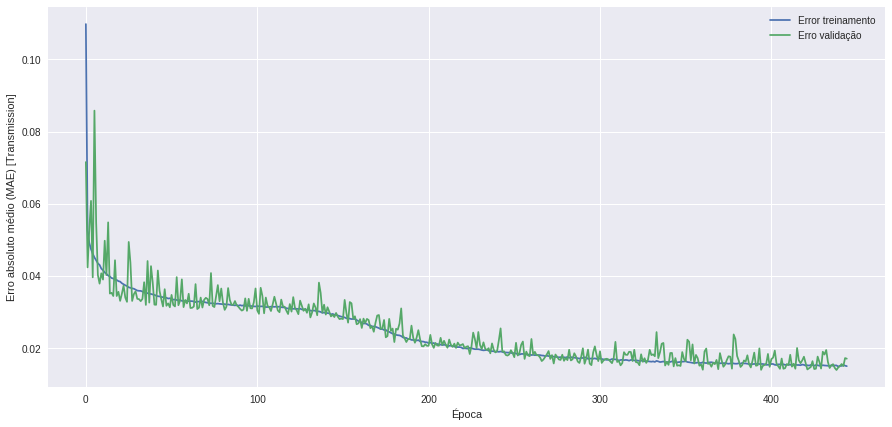

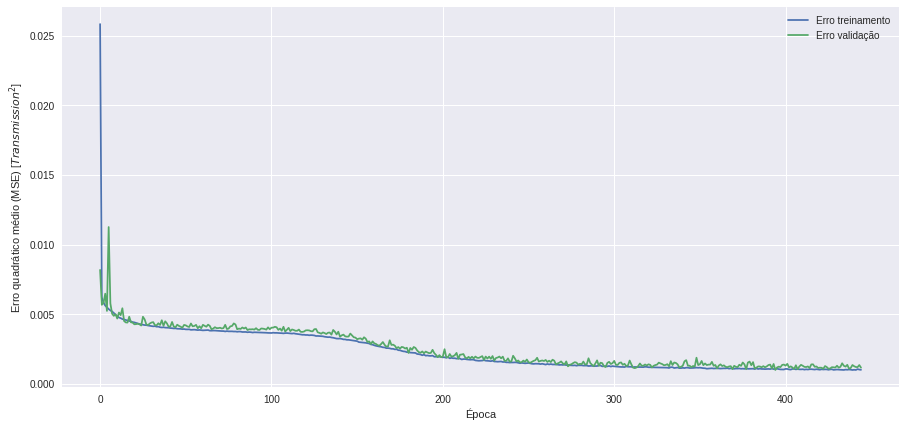

In [31]:
plot_history(history)

In [32]:
normed_train_data

,Energy,n_x,g_x,b,alpha,d1
28021,-1.577894,-0.416964,-0.363468,0.103411,0.907064,-0.199618
28147,-0.706390,-0.416964,-0.363468,0.103411,0.907064,-0.199618
6024,-1.557144,0.665975,0.561497,0.103411,-0.536537,-0.199618
53420,1.181868,2.464799,1.023980,0.825806,-0.706372,1.318620
38715,-0.236055,-0.146229,-0.132226,0.103411,0.482476,-0.199618
503,-1.702394,1.072077,0.908359,0.103411,1.841159,-0.199618
10133,-0.803224,0.665975,0.561497,0.103411,0.397558,-0.199618
54576,-1.197476,3.050523,1.370841,-1.582179,0.142805,1.318620
4901,1.050451,1.072077,0.908359,0.103411,0.567394,-0.199618
16222,-0.187638,-1.499903,-1.288432,0.103411,-0.791290,-0.199618


O gráfico mostra que no conjunto de validação, a média do erro é de aproximadamente +/- 0.024 para Transmission.

Abaixo é mostrado o erro médio absoluto para o conjunto de **test**, o qual não foi usado para treinar o modelo:

### Predição

Abaixo segue o gráfico dos valores de Transmissão reais vs preditos no conjunto de teste:

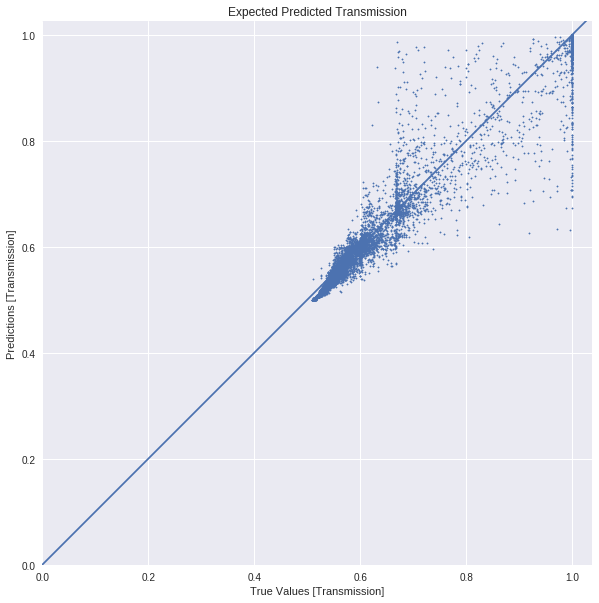

In [33]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=[20,10])
plt.title('Expected Predicted Transmission')
# color = np.sqrt((test_labels - test_predictions)**(test_labels - test_predictions))
# plt.scatter(test_labels, test_predictions, s=2, c=['blue','red'])
plt.scatter(test_labels, test_predictions, s=2)
plt.xlabel('True Values [Transmission]')
plt.ylabel('Predictions [Transmission]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


In [34]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.4f} Transmission".format(mae))
print("Testing set Mean Squared Error: {:5.4f} Transmission".format(mse))
print("Testing set R2 Score: {:5.4f} Transmission".format(calc_r2_score(test_labels, test_predictions)))

Testing set Mean Abs Error: 0.0170 Transmission
Testing set Mean Squared Error: 0.0011 Transmission
Testing set R2 Score: 0.9659 Transmission


In [35]:
model

In [36]:
dataset.query('n_x==1977').groupby(['alpha', 'n_x','d1','b','g_x'] ).count()

,,,,,Energy,Transmission
alpha,n_x,d1,b,g_x,,
0.00,1977.0,11.076,3.124,19.0,500,500
0.01,1977.0,11.076,3.124,19.0,500,500
0.05,1977.0,11.076,3.124,19.0,500,500
0.13,1977.0,11.076,3.124,19.0,500,500
0.18,1977.0,11.076,3.124,19.0,500,500
0.24,1977.0,11.076,3.124,19.0,500,500
0.26,1977.0,11.076,3.124,19.0,500,500
0.27,1977.0,11.076,3.124,19.0,500,500
0.28,1977.0,11.076,3.124,19.0,500,500


### Gráfico de Transmission por Energy

Abaixo seguem gráficos de configurações específicas de nanofitas de grafeno. Dentre elas:
n_x=2081 e alpha=11; 
n_x=417 e alpha=1; 
n_x=1977 e alpha=18.

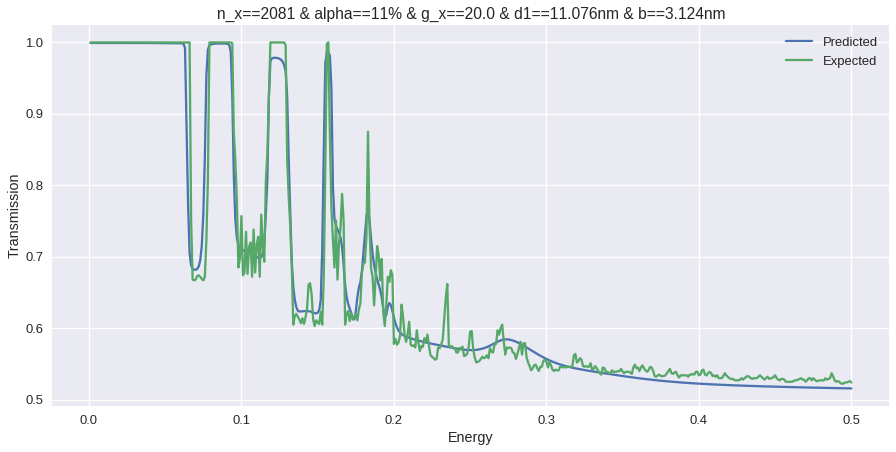

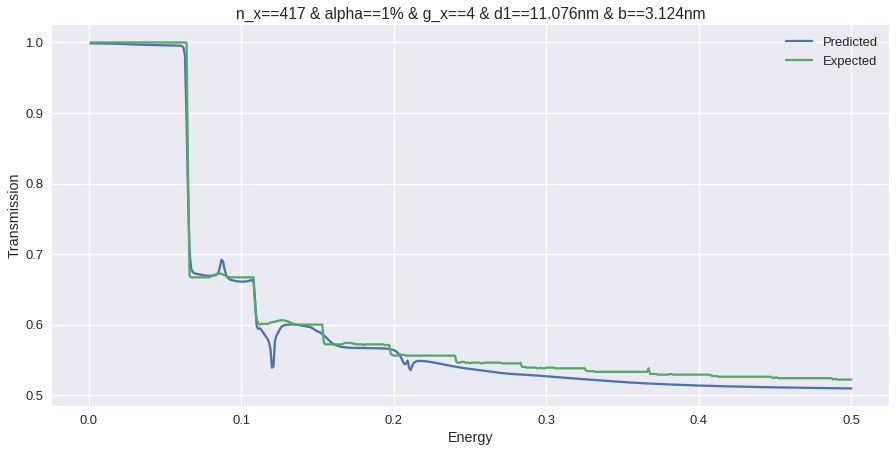

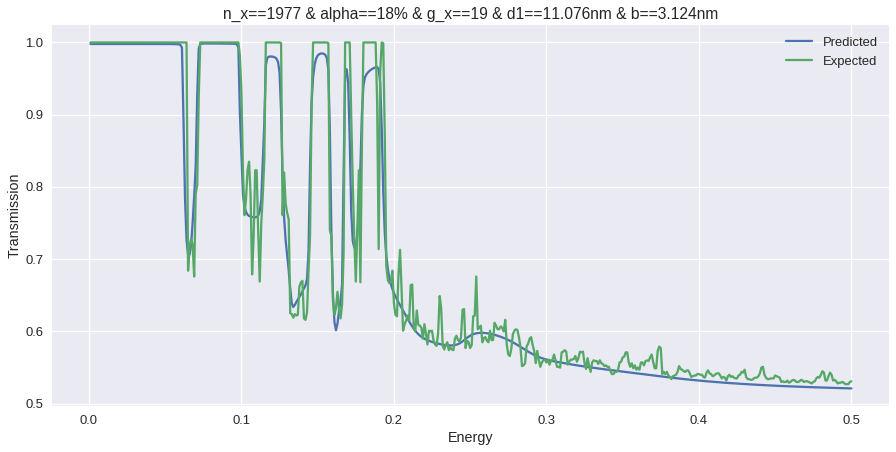

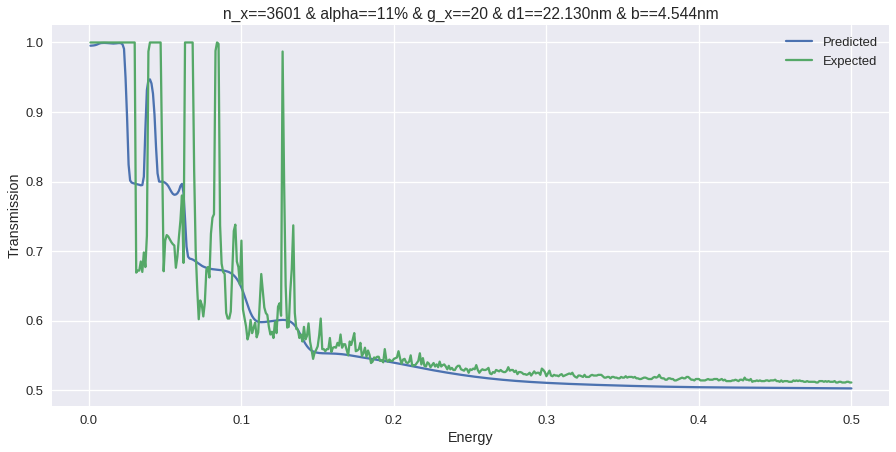

In [37]:
# sns.set()
sns.set_context("talk")
QUERY = 'n_x==2081 & alpha==0.11'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)

normed_queried_data  = norm(queried_data)
# normed_queried_data
# normed_queried_data.reset_index(drop=True)
# normed_queried_data

queried_predictions = model.predict(normed_queried_data).flatten()
queried_predictions

plt.figure(figsize=[15,7])
plt.title('n_x==2081 & alpha==11% & g_x==20.0 & d1==11.076nm & b==3.124nm')
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.plot(queried_data['Energy'],queried_predictions, label = 'Predicted')
plt.plot(queried_data['Energy'],queried_data_all['Transmission'], label = 'Expected')
plt.legend()
plt.show()

QUERY = 'n_x==417 & alpha==0.01'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)
normed_queried_data  = norm(queried_data)
queried_predictions = model.predict(normed_queried_data).flatten()
queried_predictions

plt.figure(figsize=[15,7])
plt.title('n_x==417 & alpha==1% & g_x==4 & d1==11.076nm & b==3.124nm')
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.plot(queried_data['Energy'],queried_predictions, label='Predicted')
plt.plot(queried_data['Energy'],queried_data_all['Transmission'], label='Expected')
plt.legend()
plt.show()

QUERY = 'n_x==1977 & alpha==0.18'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)
normed_queried_data  = norm(queried_data)
queried_predictions = model.predict(normed_queried_data).flatten()
queried_predictions

plt.figure(figsize=[15,7])
plt.title('n_x==1977 & alpha==18% & g_x==19 & d1==11.076nm & b==3.124nm')
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.plot(queried_data['Energy'],queried_predictions, label='Predicted')
plt.plot(queried_data['Energy'],queried_data_all['Transmission'], label='Expected')
plt.legend()
plt.show()

QUERY = 'n_x==3601 & alpha==0.11'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)
normed_queried_data  = norm(queried_data)
queried_predictions = model.predict(normed_queried_data).flatten()
queried_predictions

plt.figure(figsize=[15,7])
plt.title('n_x==3601 & alpha==11% & g_x==20 & d1==22.130nm & b==4.544nm')
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.plot(queried_data['Energy'],queried_predictions, label='Predicted')
plt.plot(queried_data['Energy'],queried_data_all['Transmission'], label='Expected')
plt.legend()
plt.show()

### Histograma de contagem de erros por intervalo

Percebe-se no gráfico abaixo que para o conjunto  **test** (não conhecido pela rede), pouquíssimos erros maiores que |0.15| foram encontrados

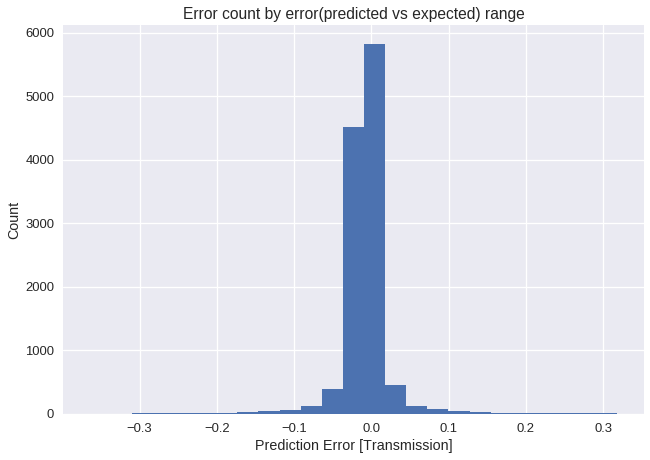

In [38]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.title('Error count by error(predicted vs expected) range')
plt.xlabel("Prediction Error [Transmission]")
_ = plt.ylabel("Count")
plt.show()
# sns.distplot(error, kde=False)

### Inferência de transmissão para configurações desconhecidas

In [0]:

min_Energy = min(dataset['Energy'])
max_Energy = max(dataset['Energy'])

min_n_x = min(dataset['n_x'])
max_n_x = max(dataset['n_x'])

min_g_x = min(dataset['g_x'])
max_g_x = max(dataset['g_x'])

min_b = min(dataset['b'])
max_b = max(dataset['b'])

min_alpha = min(dataset['alpha'])
max_alpha = max(dataset['alpha'])

min_d1 = min(dataset['d1'])
max_d1 = max(dataset['d1'])

# print("min_Energy", min_Energy)
# print("max_Energy", max_Energy)
# print("min_n_x", min_n_x)
# print("max_n_x", max_n_x)
# print("min_g_x", min_g_x)
# print("max_g_x", max_g_x)
# print("min_b", min_b)
# print("max_b", max_b)
# print("min_alpha", min_alpha)
# print("max_alpha", max_alpha)
# print("min_d1", min_d1)
# print("max_d1", max_d1)

series_Energy, step_Energy = np.linspace(min_Energy, max_Energy, num=500, endpoint=True, retstep=True, dtype=float)
series_n_x, step_n_x = np.linspace(min_n_x, max_n_x, num=500, endpoint=True, retstep=True, dtype=float)
series_g_x, step_g_x = np.linspace(min_g_x, max_g_x, num=500, endpoint=True, retstep=True, dtype=float)
series_b, step_b = np.linspace(min_b, max_b, num=500, endpoint=True, retstep=True, dtype=float)
series_alpha, step_alpha = np.linspace(min_alpha, max_alpha, num=50, endpoint=True, retstep=True, dtype=float)
series_d1, step_d1 = np.linspace(min_d1, max_d1, num=500, endpoint=True, retstep=True, dtype=float)

# step_Energy = 0.001
# step_n_x = 40
# step_g_x = 5
# step_b = 0.1
# step_alpha = 0.05
# step_d1 = 1

# print("step_Energy", step_Energy)
# print("step_n_x", step_n_x)
# print("step_g_x", step_g_x)
# print("step_b", step_b)
# print("step_alpha", step_alpha)
# print("step_d1", step_d1)

# alpha n_x     d1      b     g_x   
# 0.00  1977.0  11.076  3.124 19.0  

all_generated_dataframe = []
for alpha_value in series_alpha:
  generated_dataframe = pd.DataFrame({'Energy': series_Energy,
                                          'n_x': 1977.0,
                                          'g_x': 19.0,
                                          'b': 3.124,
                                          'alpha': alpha_value,
                                          'd1': 11.076
                                          },
                                          dtype=np.float
                                    )
  # generated_dataframe

  queried_data = generated_dataframe
  # queried_data
  # queried_data.query('n_x==1977').groupby(['alpha', 'n_x','d1','b','g_x'] ).count()

  queried_data.sort_values(by='Energy', ascending=True, inplace=True)

  normed_queried_data  = norm(queried_data)
  normed_queried_data = normed_queried_data[["Energy","n_x","g_x","b","alpha","d1"]]
  # normed_queried_data.head()

  queried_predictions = model.predict(normed_queried_data).flatten()
  generated_dataframe['Transmission'] = queried_predictions
  all_generated_dataframe.append(generated_dataframe)
  # # queried_predictions
  plt.figure(figsize=[15,7])
  # plt.title('n_x==1977 & alpha==18% & g_x==19 & d1==11.076nm & b==3.124nm')
  plt.xlabel('Energy')
  plt.ylabel('Transmission')
  plt.plot(queried_data['Energy'],queried_predictions, label='Predicted')
  # plt.plot(queried_data['Energy'],queried_data_all['Transmission'], label='Expected')
  plt.legend()
  plt.show()

QUERY = 'n_x==1977 & alpha==0.18'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)
normed_queried_data  = norm(queried_data)
normed_queried_data.head()
# queried_data_all.pop('Transmission')
# queried_data_all

def f(x, y):
  return x+y
 
x = np.linspace(0, 5, 5)
y = np.linspace(0, 5, 4)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)


# generated_dataframe = pd.DataFrame({'Energy': series_Energy,
#                                         'n_x': 1977.0,
#                                         'g_x': 19.0,
#                                         'b': 3.124,
#                                         'alpha': series_Energy * 2,
#                                         'd1': 11.076
#                                         },
#                                         dtype=np.float
#                                   )

generated_dataframe = pd.concat(all_generated_dataframe, ignore_index=True)

queried_data = generated_dataframe
# queried_data
# queried_data.query('n_x==1977').groupby(['alpha', 'n_x','d1','b','g_x'] ).count()

queried_data.sort_values(by='Energy', ascending=True, inplace=True)

normed_queried_data  = norm(queried_data)
normed_queried_data = normed_queried_data[["Energy","n_x","g_x","b","alpha","d1"]]
# normed_queried_data.head()

queried_predictions = model.predict(normed_queried_data).flatten()

generated_dataframe['Transmission'] = queried_predictions

x = generated_dataframe['Energy']
y = generated_dataframe['alpha']
X, Y = np.meshgrid(x, y)
Z = np.log(np.exp(generated_dataframe['Transmission'],X),X)

# print(Z)
plt.contour(X, Y, Z, 10, cmap='RdGy');

# contours = plt.contour(X, Y, Z, 10, colors='black')
# plt.clabel(contours, inline=True, fontsize=8)

# plt.imshow(Z, extent=[0, 5, 0, 5], origin='lower',
#             cmap='RdGy', alpha=0.5)
plt.colorbar();
plt.show()

QUERY = 'n_x==1977 & alpha==0.18'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)
normed_queried_data  = norm(queried_data)
normed_queried_data.head()
# queried_data_all.pop('Transmission')
# queried_data_all

In [0]:
alpha_0 = 0.04
while alpha_0 < 20:
  energy_0 = 0.001
  while energy_0 < 0.5
  

In [1]:
notNormalized = [0.001, 2000, 20, 4.55, 0.1, 5.02]

normalized = norm(notNormalized)

print(notNormalized)

print(normalized)

NameError: ignored

In [0]:
QUERY = 'n_x==1977 & alpha==0.18'
queried_data = dataset[["Energy", "n_x", "g_x", "b", "alpha", "d1"]].query(QUERY)
queried_data_all = dataset.query(QUERY)
normed_queried_data  = norm(queried_data)
normed_queried_data.head()
# queried_data_all.pop('Transmission')
# queried_data_all

## Conclusão

Este notebook apresenta algumas técnicas usadas para tratar um problema de regressão.

* Mean Squared Error (MSE) é uma função de custo comumente usada em problemas de regressão;
* De maneira similar, a métrica de avaliação Mean Absolute Error (MAE) é comumente usada em problemas de regressão;
* Quando cada variável de entrada tem intervalos diferentes, cada variável deve ser escalada de maneira independente;
* Early stopping é uma técnica usada para prevenir overfitting